# Exercise 3. (Kalman Filter for Noisy Resonator)

Consider the following dynamic model:

$$x_k = \begin{pmatrix}
  cos(\omega) & \frac{sin(\omega}{\omega}\\
  - \omega sin(\omega) & cos(\omega)
  \end{pmatrix} x_{k-1} + q_{k-1}$$
  
 $$y_k = \begin{pmatrix}
  1 &  0
  \end{pmatrix} x_{k-1} + r_{k}$$
  
where $x_k \in \mathbb{R}^2$ is the state, $y_k$ is the measurement, $r_k \sim N(0, 0.1)$ is a white
Gaussian measurement noise, and $q_k \sim N(0,Q)$, where

$$Q = \begin{pmatrix}
  \frac{q^c \omega -q^c cos(\omega)sin(\omega)}{2\omega^3} &  \frac{q^c (sin(\omega))^2}{2\omega^2} \\
  \frac{q^c (sin(\omega))^2}{2\omega^2} &  \frac{q^c \omega +q^c cos(\omega)sin(\omega)}{2\omega} 
  \end{pmatrix} $$

In [1]:
import scipy.io as sio
from filterpy.kalman import KalmanFilter
import numpy as np
from scipy.linalg import solve_discrete_are
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
steps=100
X = sio.loadmat('X.mat')['X']
y = sio.loadmat('Y.mat')['Y']

In [3]:
X.shape


(2, 100)

In [4]:
y.shape

(1, 100)

In [5]:
X = X.swapaxes(0,1)
y = y.reshape(-1,1)

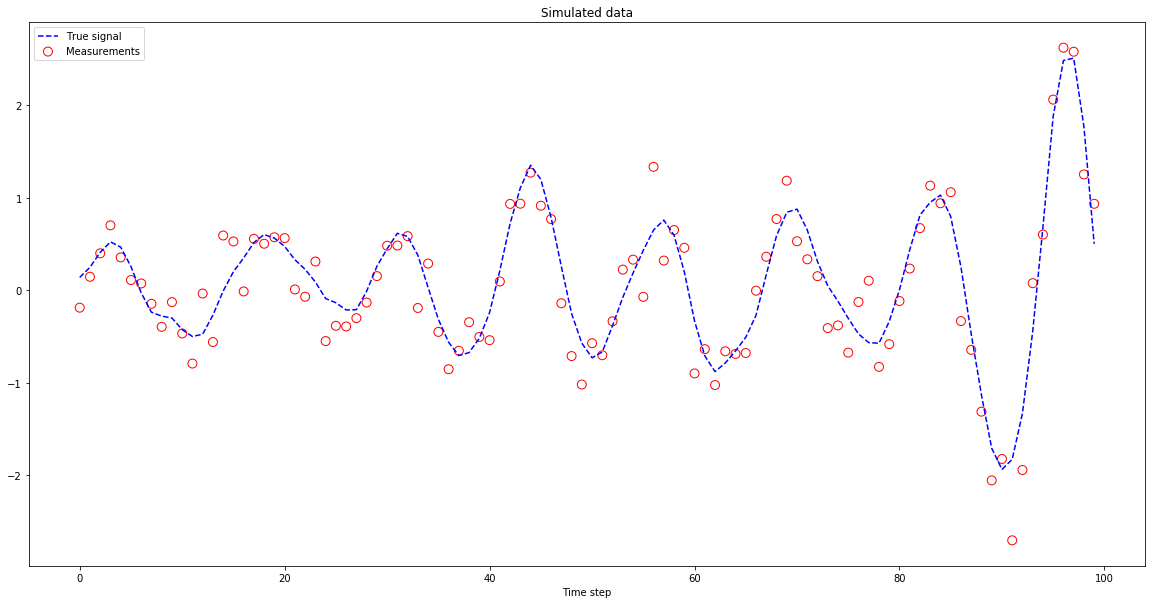

In [6]:
plt.figure(figsize=(20,10))
t = np.linspace(0,steps-1,steps)
plt.scatter(x=t,y=y.flatten(),label = 'Measurements',s=80, facecolors='none', edgecolors='r')
#plt.plot(t,x,label = "True signal",linestyle='--')
plt.plot(t,X[:,0],label = "True signal",linestyle='--',color='b')
plt.title('Simulated data')
plt.xlabel('Time step')
plt.legend()
plt.show()

# Baseline solution

In [7]:
m1 = np.array([0,1])
m1.shape
EST1 = np.zeros((steps,2))
for k in range(steps):
    m1  = np.array([y[k][0],(y[k]-m1[0])[0]])
    EST1[k] = m1

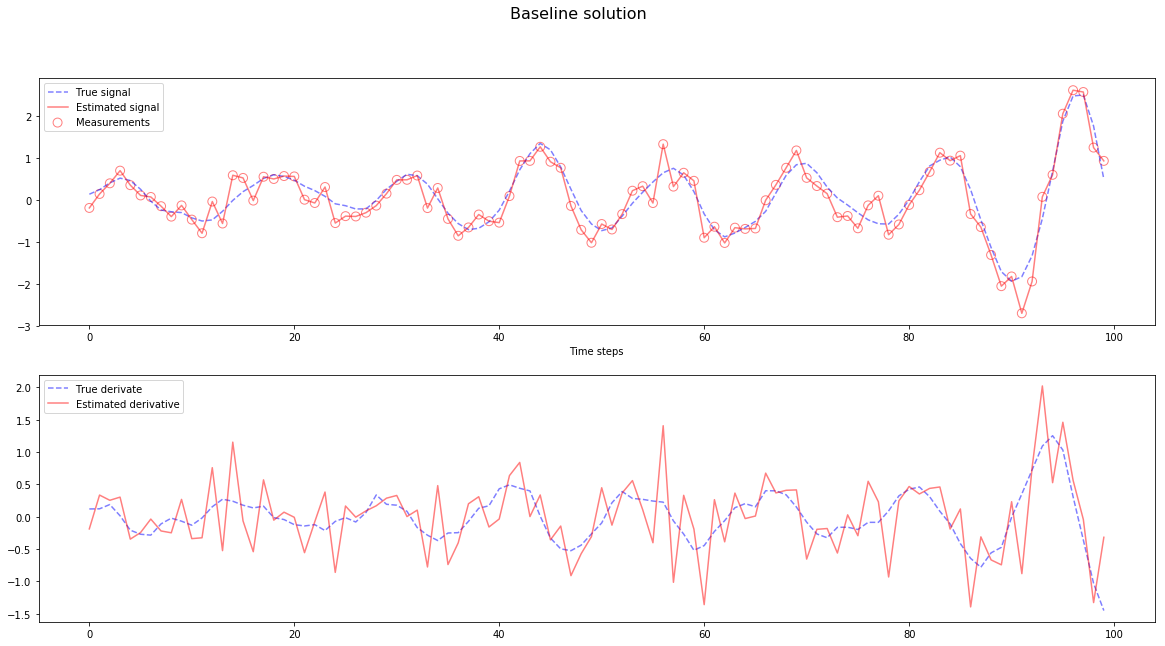

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,10))
f.suptitle("Baseline solution", fontsize=16)
ax1.scatter(x=t,y=y.flatten(),label = 'Measurements',s=80, facecolors='none', edgecolors='r',alpha=0.5)
ax1.plot(t,X[:,0],label = "True signal",linestyle='--',color='b',alpha=0.5)
ax1.plot(t,EST1[:,0],label = "Estimated signal",linestyle='-',color='r',alpha=0.5)
ax1.set_xlabel('Time steps')
ax1.legend()


ax2.plot(t,X[:,1],label = "True derivate",linestyle='--',color='b',alpha=0.5)
ax2.plot(t,EST1[:,1],label = "Estimated derivative",linestyle='-',color='r',alpha=0.5)
ax2.legend()
ax1.set_xlabel('Time steps')
plt.show()

In [9]:
#RMSE
np.sqrt(mean_squared_error(X,EST1))

0.3818207048796625

# Kalman filter

In [10]:
omega = 0.5
q_c  = 0.01
A = np.array([[np.cos(omega),np.sin(omega)/omega],[-omega*np.sin(omega),np.cos(omega)]])
Q = np.array([[(q_c*omega- q_c*np.cos(omega)*np.sin(omega))/(2*omega**3),
               (q_c*omega*np.sin(omega)**2)/(2*omega**2)]
              ,[(q_c*omega*np.sin(omega)**2)/(2*omega**2),
                (q_c*omega+ q_c*np.cos(omega)*np.sin(omega))/(2*omega)]])
R = np.array([[0.1]])
H = np.array([[1,0]])

In [11]:
filterPy = False

In [12]:
if not filterPy:
    m2 = np.array([[0],[1]])
    P2 = np.eye(2)
    EST2 = np.zeros((steps,2))
    for k in range(steps):
        m2_ = A @ m2
        P2_ = A @ P2 @A.T + Q
        v_k = y[k] - H@m2_
        S_k = H@P2_@H.T + R
        K_k = P2_@H.T@np.linalg.inv(S_k)
        m2 = m2_ + K_k @ v_k
        P2 = P2_ - K_k @S_k@K_k.T
        EST2[k] = m2.flatten()

In [13]:
#same using filterpy
if filterPy:
    m = np.array([0,1])
    P = np.eye(2)
    f = KalmanFilter (dim_x=2, dim_z=1)
    y_k = np.array(y).flatten().reshape(steps,1)
    f.x = m
    f.F = A
    f.H = H
    f.P = P
    f.Q = Q
    f.R = R
    m_array = np.zeros((steps,2))
    for k in range(100):
          f.predict()
          f.update(y_k[k])
          m_array[k] = f.x
    EST2 = m_array

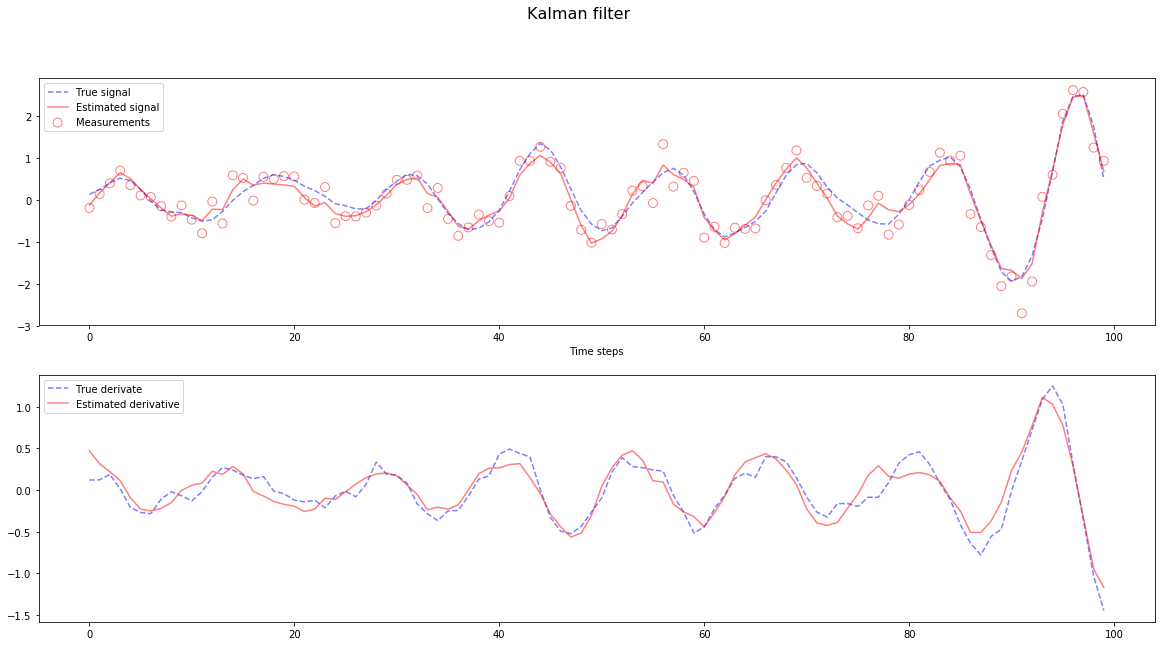

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,10))
f.suptitle("Kalman filter", fontsize=16)
ax1.scatter(x=t,y=y.flatten(),label = 'Measurements',s=80, facecolors='none', edgecolors='r',alpha=0.5)
ax1.plot(t,X[:,0],label = "True signal",linestyle='--',color='b',alpha=0.5)
ax1.plot(t,EST2[:,0],label = "Estimated signal",linestyle='-',color='r',alpha=0.5)
ax1.set_xlabel('Time steps')
ax1.legend()


ax2.plot(t,X[:,1],label = "True derivate",linestyle='--',color='b',alpha=0.5)
ax2.plot(t,EST2[:,1],label = "Estimated derivative",linestyle='-',color='r',alpha=0.5)
ax2.legend()
ax1.set_xlabel('Time steps')
plt.show()

In [15]:
#RMSE
np.sqrt(mean_squared_error(X,EST2))

0.16817263193603776

# Stationary Kalman filter

In [16]:
m3 = np.array([[0],[1]])
P3 = np.eye(2)
K  = np.array([[0],[0]])
EST3 = np.zeros((steps,2))
P3_ = solve_discrete_are(A.T,H.T,Q,R) 
K = P3_@H.T@np.linalg.inv(H@P3_@H.T+R)
   
for k in range(steps):   
    m3 = (A-K@H@A)@m3+ K*y[k]
    EST3[k] = m3.flatten()

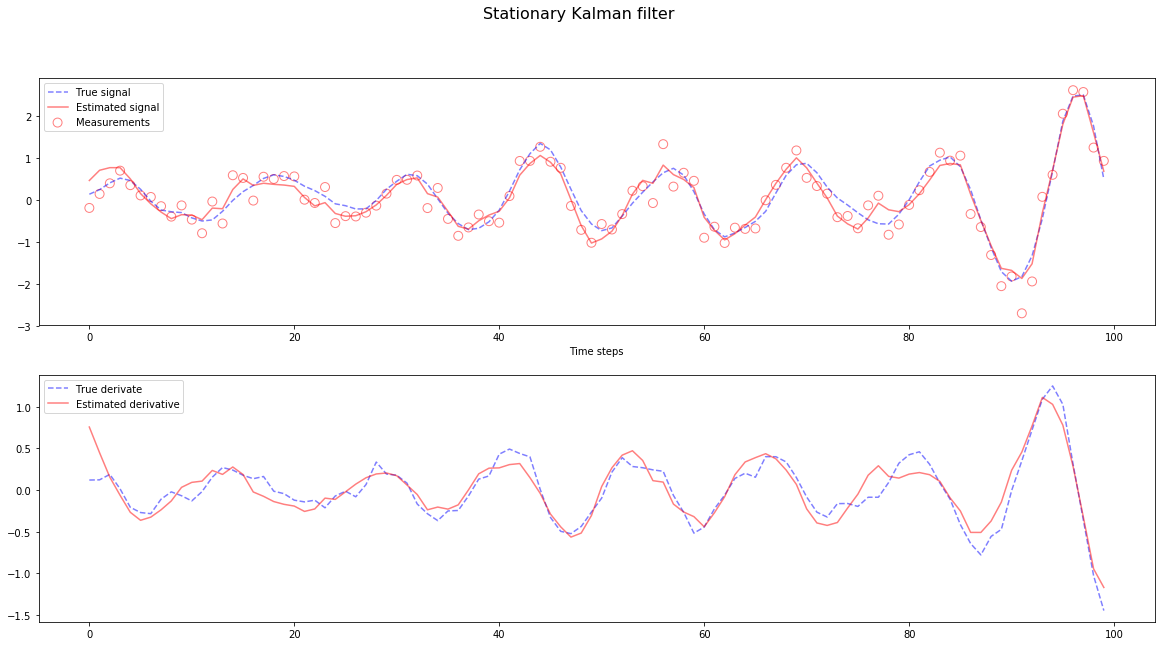

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,10))
f.suptitle("Stationary Kalman filter", fontsize=16)
ax1.scatter(x=t,y=y.flatten(),label = 'Measurements',s=80, facecolors='none', edgecolors='r',alpha=0.5)
ax1.plot(t,X[:,0],label = "True signal",linestyle='--',color='b',alpha=0.5)
ax1.plot(t,EST3[:,0],label = "Estimated signal",linestyle='-',color='r',alpha=0.5)
ax1.set_xlabel('Time steps')
ax1.legend()


ax2.plot(t,X[:,1],label = "True derivate",linestyle='--',color='b',alpha=0.5)
ax2.plot(t,EST3[:,1],label = "Estimated derivative",linestyle='-',color='r',alpha=0.5)
ax2.legend()
ax1.set_xlabel('Time steps')
plt.show()

In [18]:
#RMSE
np.sqrt(mean_squared_error(X,EST3))

0.18037847258949324